In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [36]:
def print_metrics(y_pred,y_true):
    print('MAE',mean_absolute_error(y_pred,y_true))
    print('MSE',mean_squared_error(y_pred,y_true))
    print('RMSE',root_mean_squared_error(y_pred,y_true))

In [37]:
df = pd.read_csv("US_Stock_Data.csv", index_col = 'Unnamed: 0')
df.head(10)

,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,2/2/2024,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650,901.6,...,"5,89,498",10580,564.64,4030000,171.81,117220000,474.99,84710000,"2,053.70",NaN
1,1/2/2024,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690,922.3,...,"5,81,600",9780,567.51,3150000,159.28,66360000,394.78,25140000,"2,071.10",260920.0
2,31-01-2024,2.100,142860.0,75.85,344490.0,3.9060,NaN,"42,580.50",56480,932.6,...,"5,78,020",9720,564.11,4830000,155.20,49690000,390.14,20010000,"2,067.40",238370.0
3,30-01-2024,2.077,139750.0,77.82,347240.0,3.9110,NaN,"42,946.20",55130,931.7,...,"5,84,680",9750,562.85,6120000,159.00,42290000,400.06,18610000,"2,050.90",214590.0
4,29-01-2024,2.490,3590.0,76.78,331930.0,3.8790,NaN,"43,299.80",45230,938.3,...,"5,78,800",13850,575.79,6880000,161.26,42840000,401.02,17790000,"2,034.90",1780.0
5,26-01-2024,2.712,73020.0,78.01,365460.0,3.8520,NaN,"41,811.30",69470,921.3,...,"5,82,300",10040,570.42,12770000,159.12,51050000,394.14,13160000,"2,026.60",410.0
6,25-01-2024,2.571,44980.0,77.36,320180.0,3.8690,NaN,"39,935.70",46300,894.5,...,"5,76,211",9350,562.00,9450000,157.75,43310000,393.18,15090000,"2,027.10",460.0
7,24-01-2024,2.641,65500.0,75.09,323730.0,3.8860,NaN,"40,086.00",58640,914.9,...,"5,70,977",9560,544.87,26350000,156.87,47640000,390.70,15700000,"2,025.40",800.0
8,23-01-2024,2.450,69160.0,74.37,306060.0,3.7935,NaN,"39,888.80",82670,905.5,...,"5,64,133",8640,492.19,14190000,156.02,34930000,385.20,15450000,"2,035.20",370.0
9,22-01-2024,2.419,121580.0,75.19,28910.0,3.7635,NaN,"39,556.40",85100,903,...,"5,58,316",11600,485.71,5210000,154.78,43690000,381.78,17490000,"2,031.50",330.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013 entries, 0 to 1012
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1013 non-null   object 
 1   Natural_Gas_Price  1013 non-null   float64
 2   Natural_Gas_Vol.   1009 non-null   float64
 3   Crude_oil_Price    1013 non-null   float64
 4   Crude_oil_Vol.     990 non-null    float64
 5   Copper_Price       1013 non-null   float64
 6   Copper_Vol.        976 non-null    float64
 7   Bitcoin_Price      1013 non-null   object 
 8   Bitcoin_Vol.       1013 non-null   int64  
 9   Platinum_Price     1013 non-null   object 
 10  Platinum_Vol.      636 non-null    float64
 11  Ethereum_Price     1013 non-null   object 
 12  Ethereum_Vol.      1013 non-null   int64  
 13  S&P_500_Price      1013 non-null   object 
 14  Nasdaq_100_Price   1013 non-null   object 
 15  Nasdaq_100_Vol.    1012 non-null   float64
 16  Apple_Price        1013 non-n

Aqui da pra perceber que o dataset precisa passar por um bom tratamento de dados, as datas não estão padronizadas e há dados relacionados a volume de transação nulos, além de dados com tipos errados.
Primeiramente, vou converter todos os valores de data para dd/mm/yyyy

In [39]:
df['Date'] = df['Date'].apply(lambda x : pd.to_datetime(x,dayfirst=True))

Precisa também converter os tipos de alguns dados, vou criar um dataframe auxiliar para armazenar apenas os preços

In [40]:
df_price = pd.DataFrame()
for column in df.columns:
    if 'Price' in column:
        df_price[f'{column}'] = df[f'{column}']

In [41]:
df_price

,Natural_Gas_Price,Crude_oil_Price,Copper_Price,Bitcoin_Price,Platinum_Price,Ethereum_Price,S&P_500_Price,Nasdaq_100_Price,Apple_Price,Tesla_Price,Microsoft_Price,Silver_Price,Google_Price,Nvidia_Price,Berkshire_Price,Netflix_Price,Amazon_Price,Meta_Price,Gold_Price
0,2.079,72.28,3.8215,"43,194.70",901.6,"2,309.28","4,958.61","17,642.73",185.85,187.91,411.22,22.796,142.38,661.60,"5,89,498",564.64,171.81,474.99,"2,053.70"
1,2.050,73.82,3.8535,"43,081.40",922.3,"2,304.28","4,906.19","17,344.71",186.86,188.86,403.78,23.236,141.16,630.27,"5,81,600",567.51,159.28,394.78,"2,071.10"
2,2.100,75.85,3.9060,"42,580.50",932.6,"2,283.14","4,848.87","17,137.24",184.40,187.29,397.58,23.169,140.10,615.27,"5,78,020",564.11,155.20,390.14,"2,067.40"
3,2.077,77.82,3.9110,"42,946.20",931.7,"2,343.11","4,924.97","17,476.71",188.04,191.59,408.59,23.225,151.46,627.74,"5,84,680",562.85,159.00,400.06,"2,050.90"
4,2.490,76.78,3.8790,"43,299.80",938.3,"2,317.79","4,927.93","17,596.27",191.73,190.93,409.72,23.134,153.51,624.65,"5,78,800",575.79,161.26,401.02,"2,034.90"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,2.141,59.61,2.8120,"8,059.60",961,140.81,"3,253.05","8,912.37",75.80,32.81,160.09,18.167,70.25,60.09,"3,39,188",339.26,94.60,215.22,"1,560.20"
1009,2.162,62.70,2.7935,"8,155.70",977.75,143.04,"3,237.18","8,846.45",74.60,31.27,157.58,18.393,69.76,59.98,"3,38,901",330.75,95.34,213.06,"1,574.30"
1010,2.135,63.27,2.7900,"7,759.10",969.35,144.08,"3,246.28","8,848.51",74.95,30.10,159.03,18.179,69.89,59.27,"3,40,210",335.83,95.14,212.60,"1,568.80"
1011,2.130,63.05,2.7870,"7,343.10",988.55,134.27,"3,234.85","8,793.90",74.36,29.53,158.62,18.151,68.08,59.02,"3,39,155",325.90,93.75,208.67,"1,552.40"


Vou passar um tratamento por todas as colunas, removendo as virgulas e convertendo as colunas para float64, a fim de conseguir plotar gráficos

In [42]:
for column in df_price.columns:
    df_price[f'{column}'] = df[f'{column}'].apply(lambda x: str(x).replace(',','')).astype('float64')

In [43]:
df_price.dtypes

Natural_Gas_Price    float64
Crude_oil_Price      float64
Copper_Price         float64
Bitcoin_Price        float64
Platinum_Price       float64
Ethereum_Price       float64
S&P_500_Price        float64
Nasdaq_100_Price     float64
Apple_Price          float64
Tesla_Price          float64
Microsoft_Price      float64
Silver_Price         float64
Google_Price         float64
Nvidia_Price         float64
Berkshire_Price      float64
Netflix_Price        float64
Amazon_Price         float64
Meta_Price           float64
Gold_Price           float64
dtype: object

In [44]:
df_price = df_price.set_index(df['Date'])
df = df.set_index(df['Date'])

In [45]:
df_price

,Natural_Gas_Price,Crude_oil_Price,Copper_Price,Bitcoin_Price,Platinum_Price,Ethereum_Price,S&P_500_Price,Nasdaq_100_Price,Apple_Price,Tesla_Price,Microsoft_Price,Silver_Price,Google_Price,Nvidia_Price,Berkshire_Price,Netflix_Price,Amazon_Price,Meta_Price,Gold_Price
Date,,,,,,,,,,,,,,,,,,,
2024-02-02,2.079,72.28,3.8215,43194.7,901.60,2309.28,4958.61,17642.73,185.85,187.91,411.22,22.796,142.38,661.60,589498.0,564.64,171.81,474.99,2053.7
2024-02-01,2.050,73.82,3.8535,43081.4,922.30,2304.28,4906.19,17344.71,186.86,188.86,403.78,23.236,141.16,630.27,581600.0,567.51,159.28,394.78,2071.1
2024-01-31,2.100,75.85,3.9060,42580.5,932.60,2283.14,4848.87,17137.24,184.40,187.29,397.58,23.169,140.10,615.27,578020.0,564.11,155.20,390.14,2067.4
2024-01-30,2.077,77.82,3.9110,42946.2,931.70,2343.11,4924.97,17476.71,188.04,191.59,408.59,23.225,151.46,627.74,584680.0,562.85,159.00,400.06,2050.9
2024-01-29,2.490,76.78,3.8790,43299.8,938.30,2317.79,4927.93,17596.27,191.73,190.93,409.72,23.134,153.51,624.65,578800.0,575.79,161.26,401.02,2034.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-08,2.141,59.61,2.8120,8059.6,961.00,140.81,3253.05,8912.37,75.80,32.81,160.09,18.167,70.25,60.09,339188.0,339.26,94.60,215.22,1560.2
2020-01-07,2.162,62.70,2.7935,8155.7,977.75,143.04,3237.18,8846.45,74.60,31.27,157.58,18.393,69.76,59.98,338901.0,330.75,95.34,213.06,1574.3
2020-01-06,2.135,63.27,2.7900,7759.1,969.35,144.08,3246.28,8848.51,74.95,30.10,159.03,18.179,69.89,59.27,340210.0,335.83,95.14,212.60,1568.8


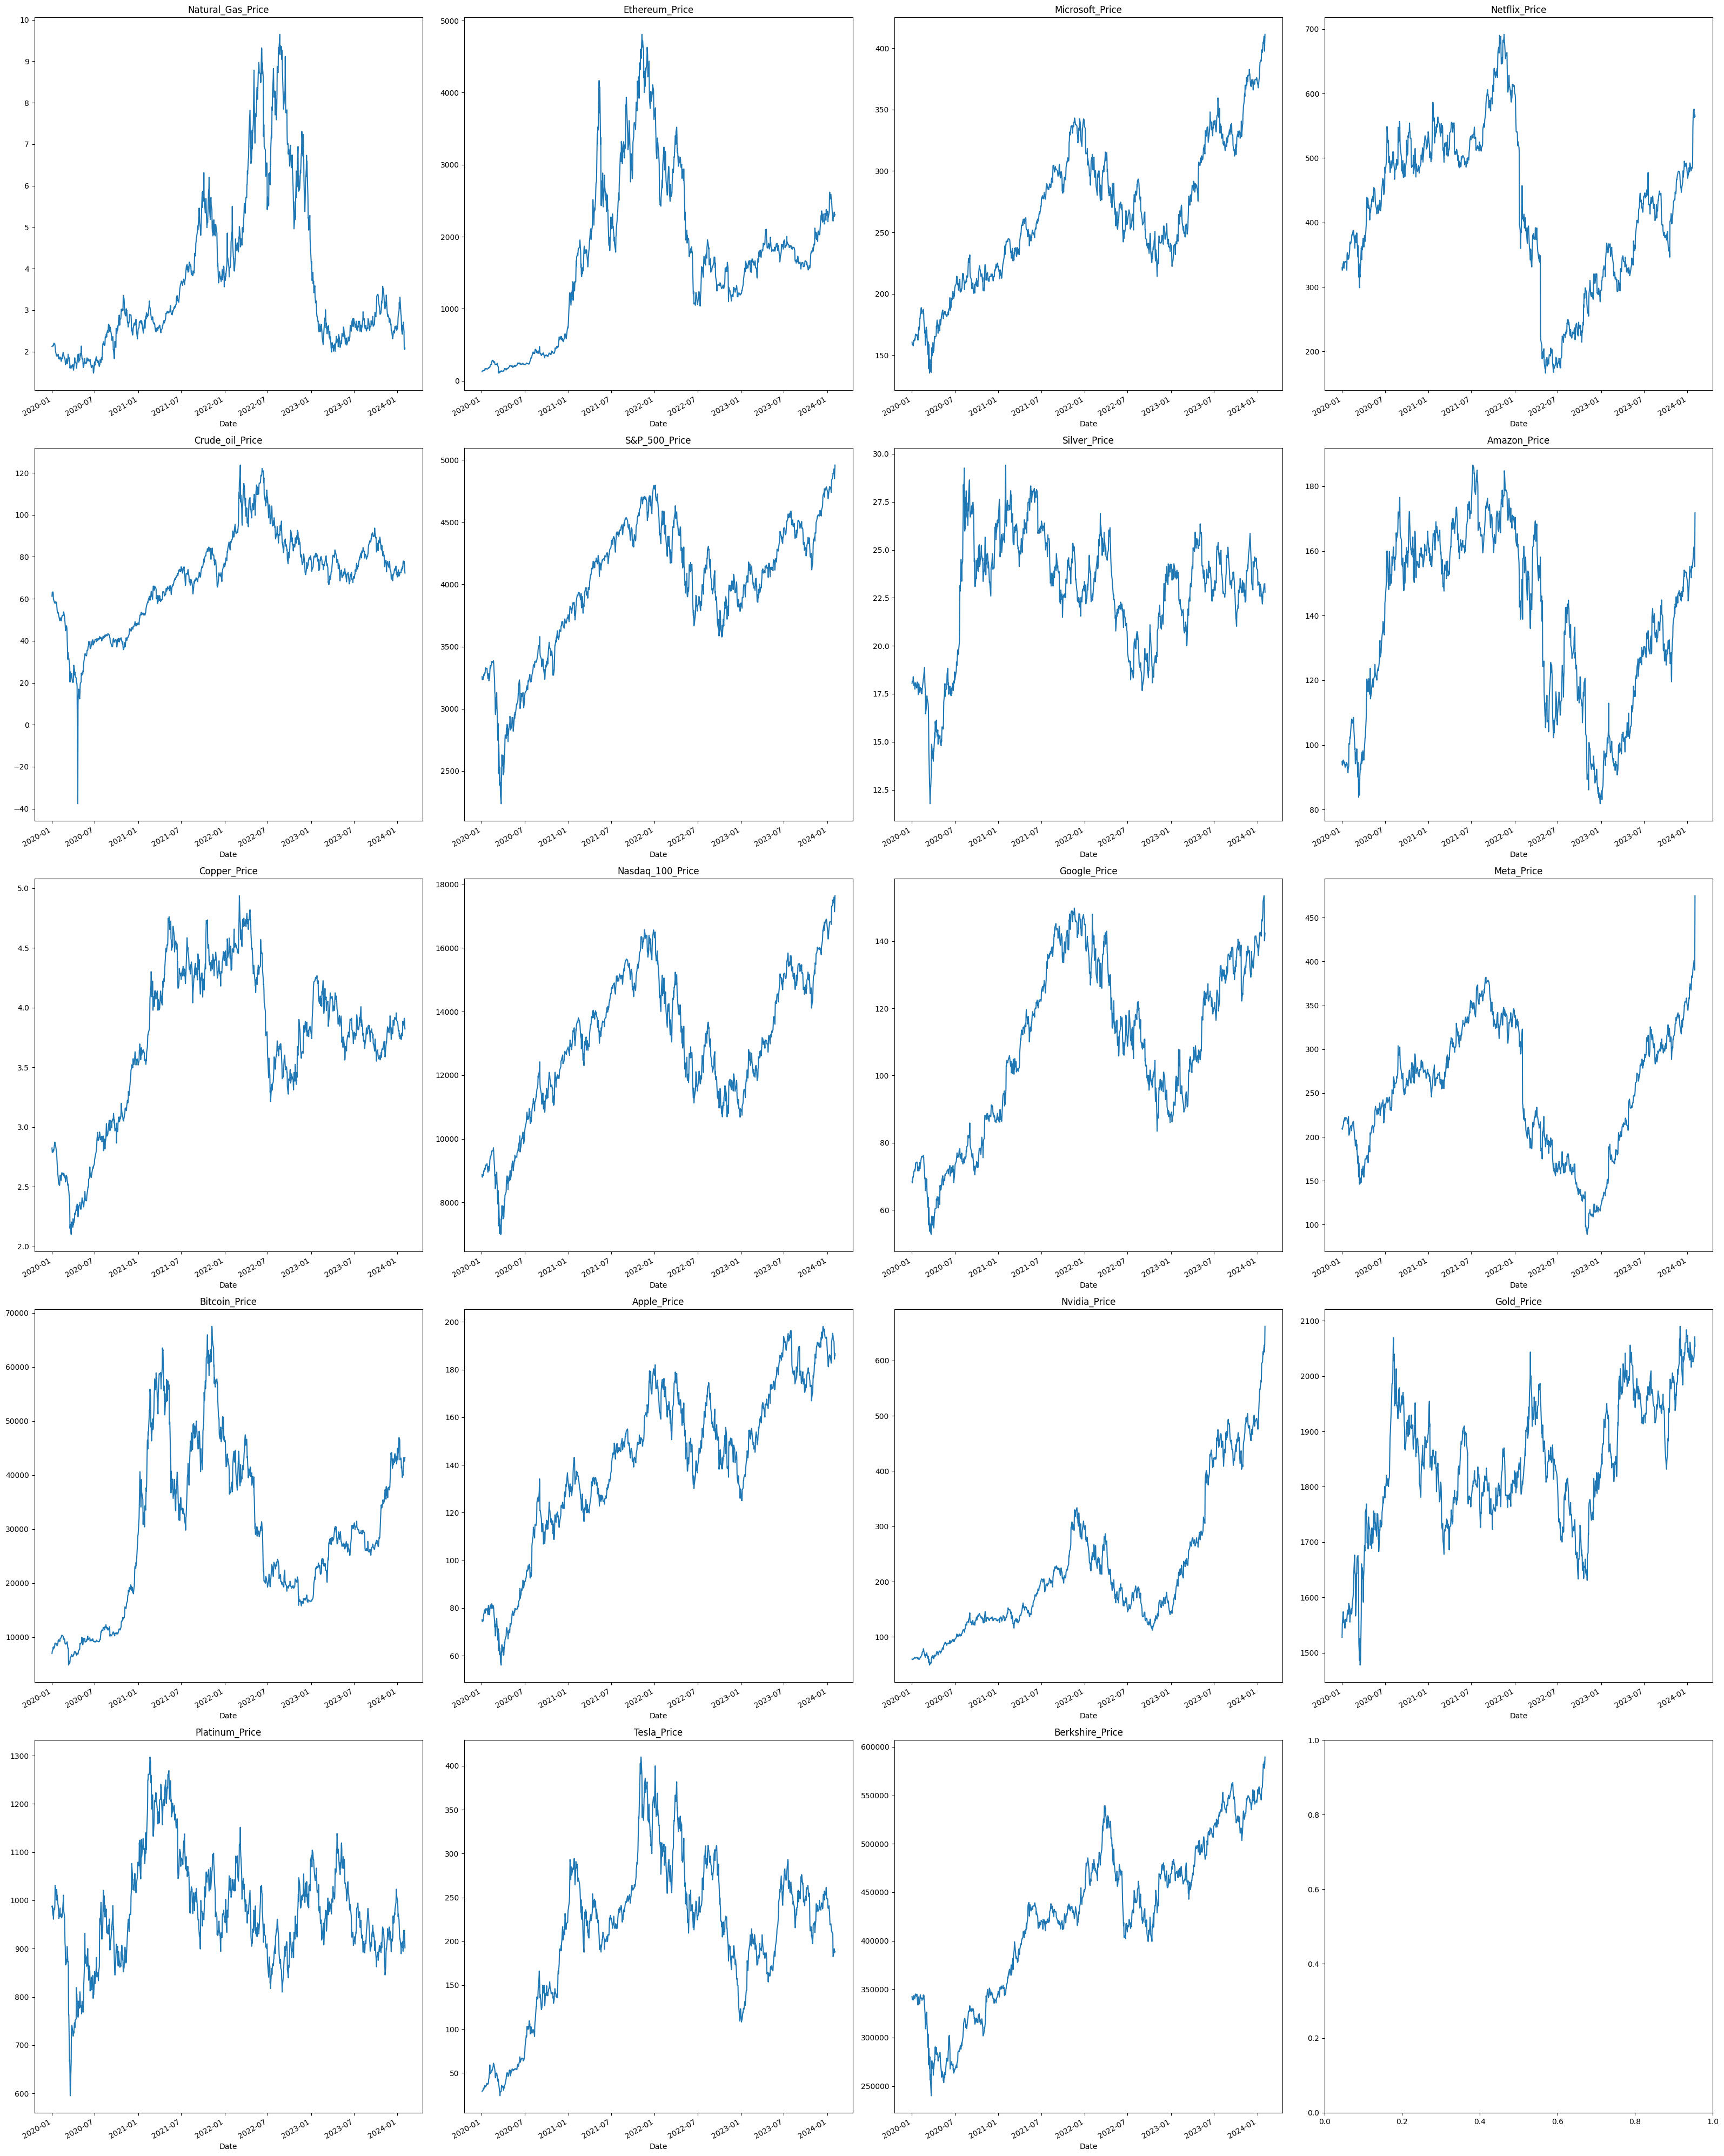

In [46]:
fig,axes = plt.subplots(nrows = 5, ncols = 4, figsize = (32,40))
for index, column in enumerate(df_price.columns):
    df_price[f'{column}'].plot(ax=axes[index%5][index//5], title=column)

plt.tight_layout()

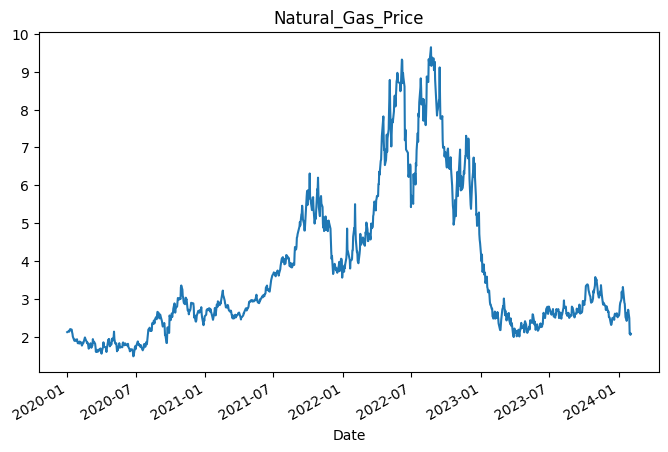

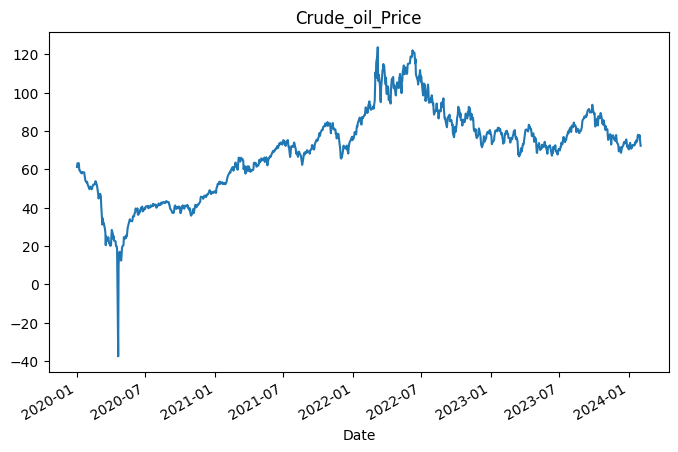

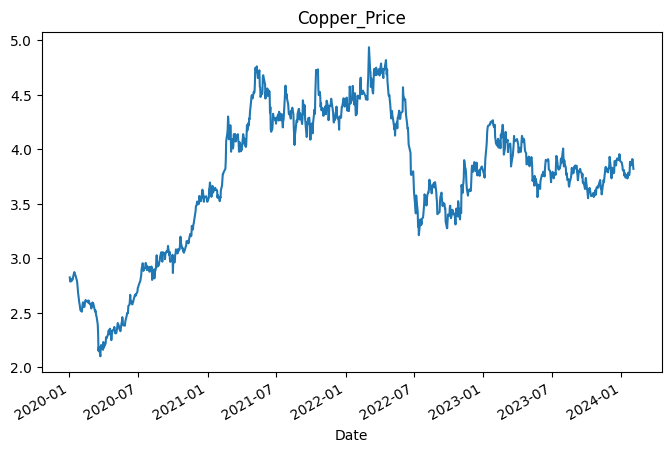

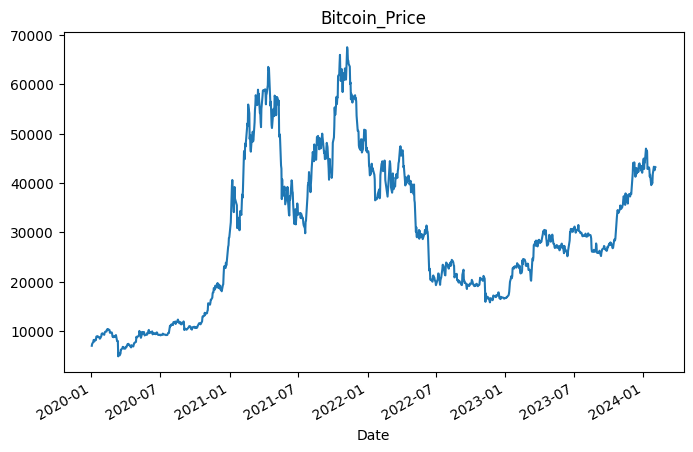

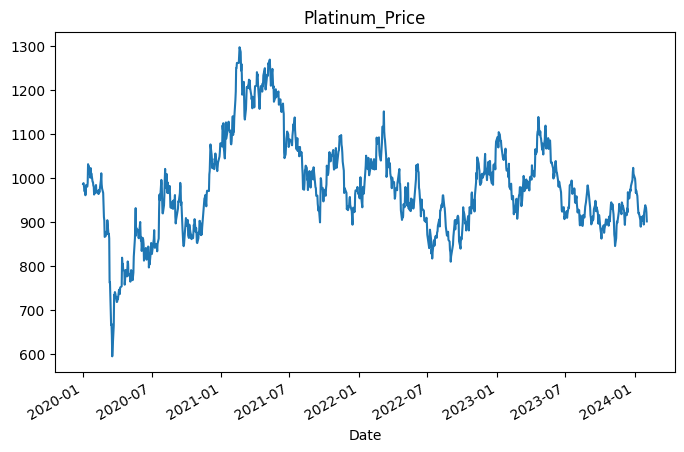

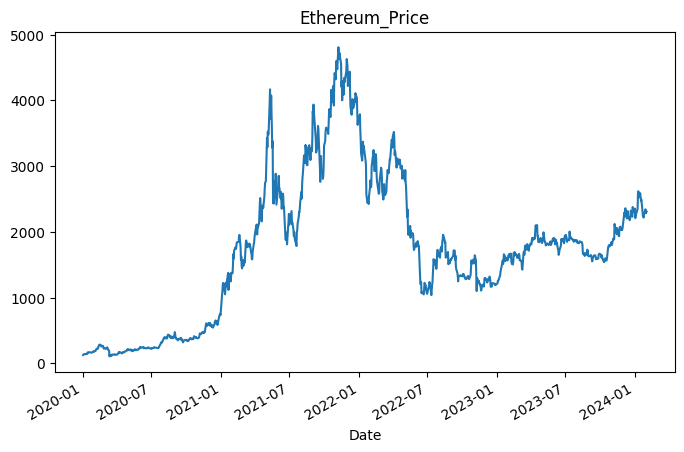

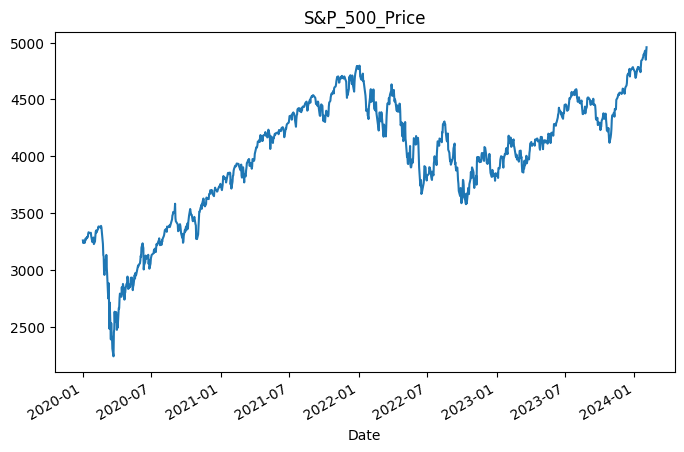

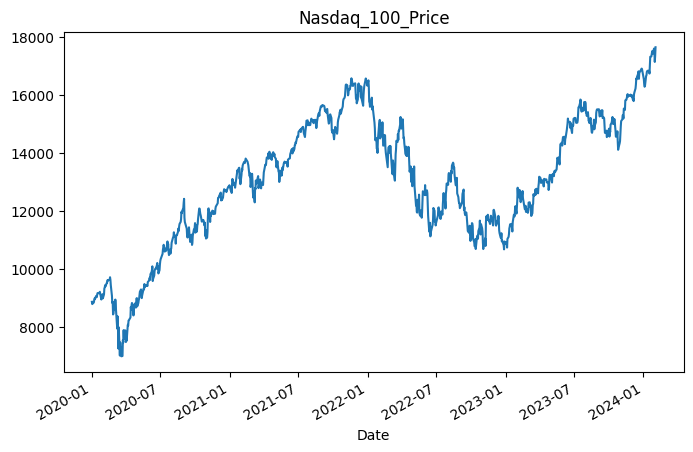

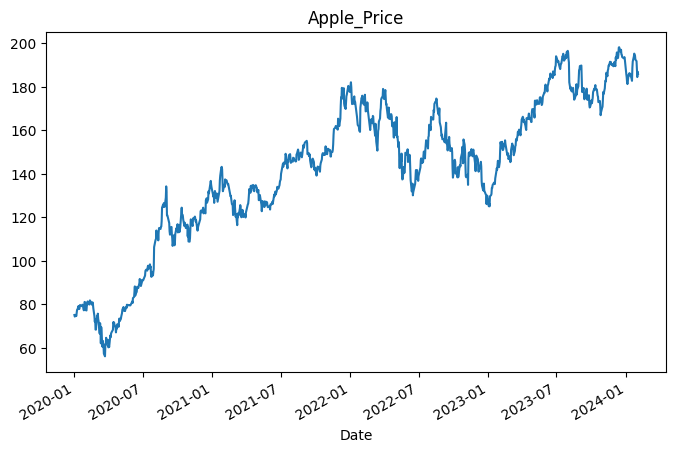

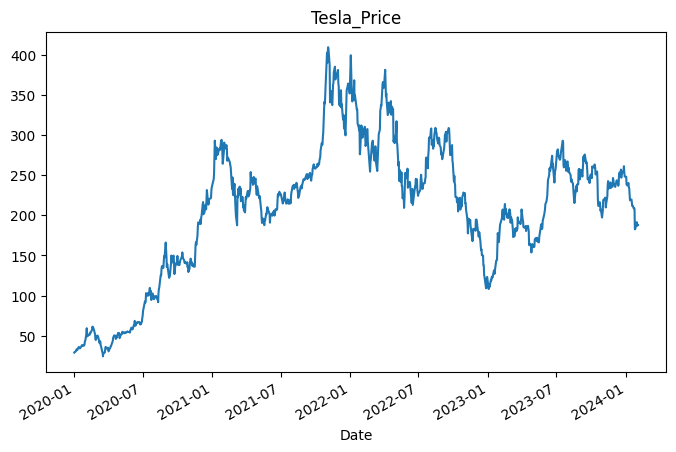

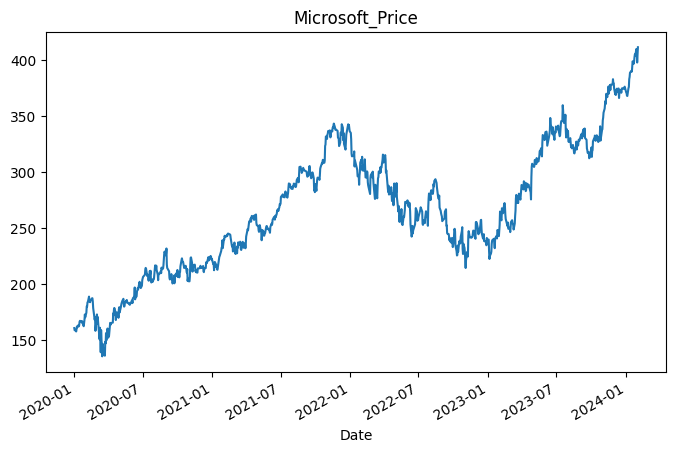

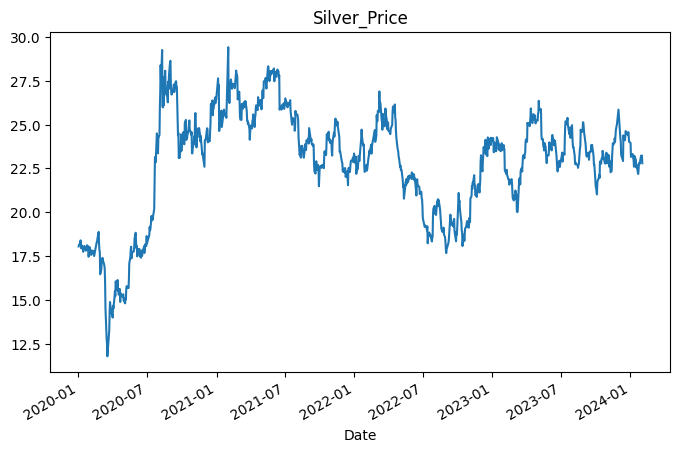

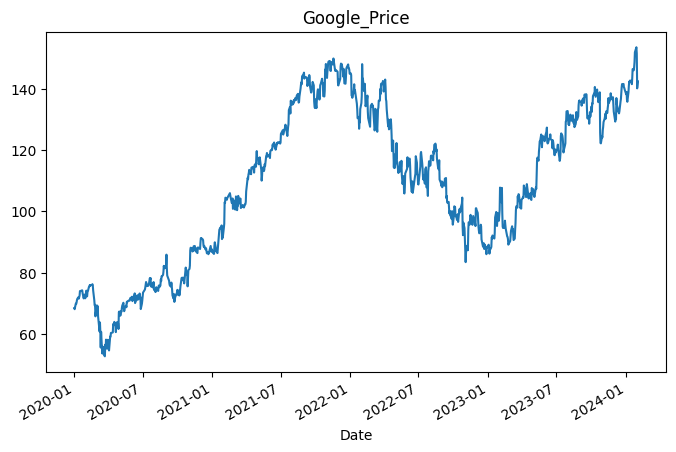

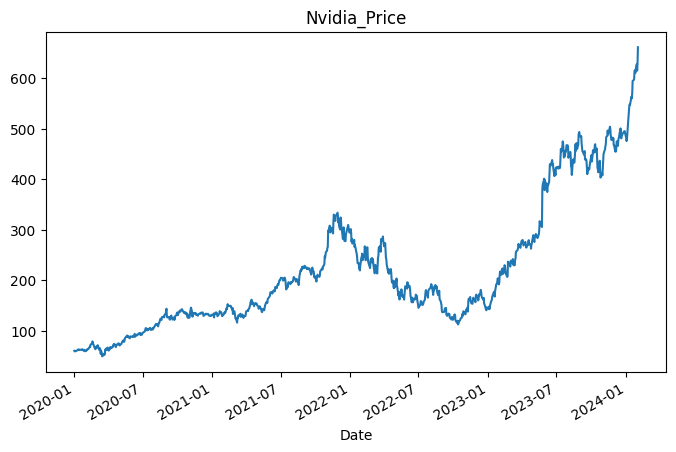

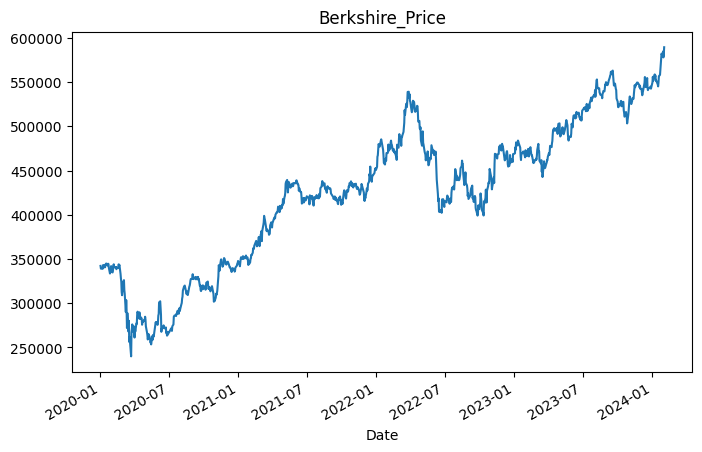

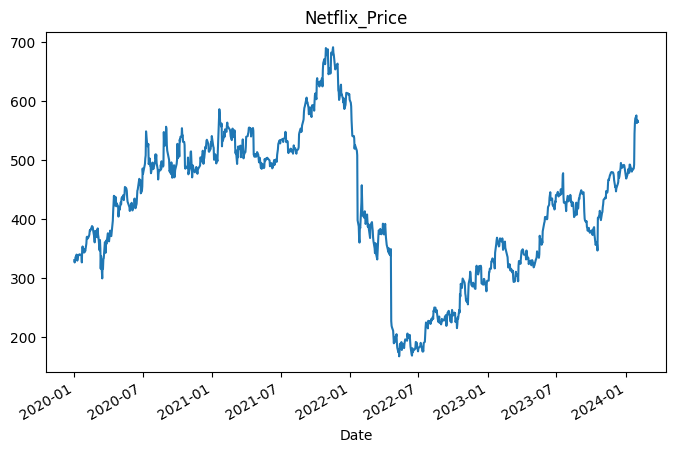

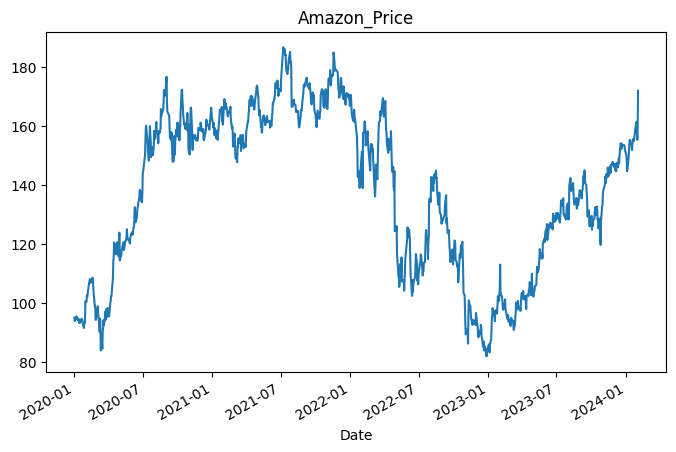

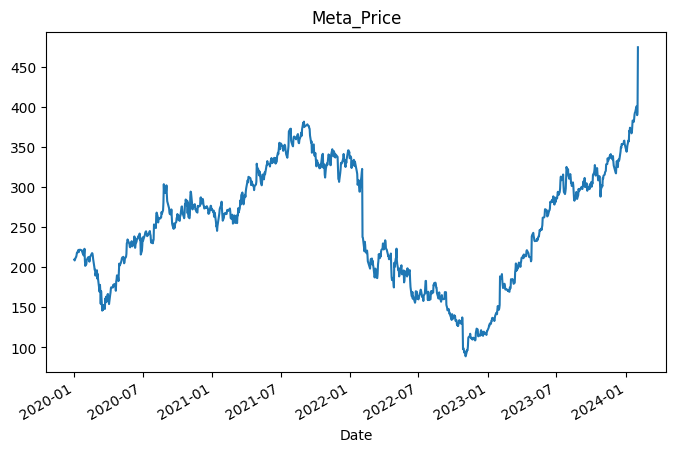

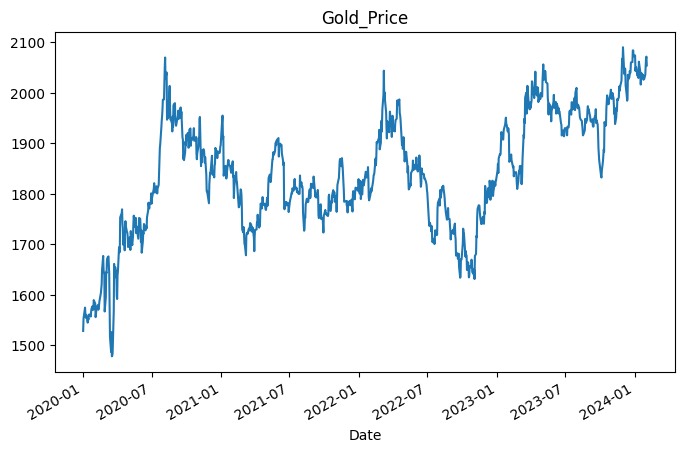

In [47]:
for index, column in enumerate(df_price.columns):
    fig = plt.figure(figsize = (8,5))
    df_price[f'{column}'].plot(title=column)
    plt.show()

Aqui da pra fazer análise de muitas empresas, mas eu vou escolher o ramo específico de Criptomoedas (Bitcoin e Ethereum)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1013 entries, 2024-02-02 to 2020-01-02
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1013 non-null   datetime64[ns]
 1   Natural_Gas_Price  1013 non-null   float64       
 2   Natural_Gas_Vol.   1009 non-null   float64       
 3   Crude_oil_Price    1013 non-null   float64       
 4   Crude_oil_Vol.     990 non-null    float64       
 5   Copper_Price       1013 non-null   float64       
 6   Copper_Vol.        976 non-null    float64       
 7   Bitcoin_Price      1013 non-null   object        
 8   Bitcoin_Vol.       1013 non-null   int64         
 9   Platinum_Price     1013 non-null   object        
 10  Platinum_Vol.      636 non-null    float64       
 11  Ethereum_Price     1013 non-null   object        
 12  Ethereum_Vol.      1013 non-null   int64         
 13  S&P_500_Price      1013 non-null   object    

In [49]:
df_cripto = df_price[['Bitcoin_Price','Ethereum_Price']]

In [50]:
df_cripto

,Bitcoin_Price,Ethereum_Price
Date,,
2024-02-02,43194.7,2309.28
2024-02-01,43081.4,2304.28
2024-01-31,42580.5,2283.14
2024-01-30,42946.2,2343.11
2024-01-29,43299.8,2317.79
...,...,...
2020-01-08,8059.6,140.81
2020-01-07,8155.7,143.04
2020-01-06,7759.1,144.08


<Axes: xlabel='Date'>

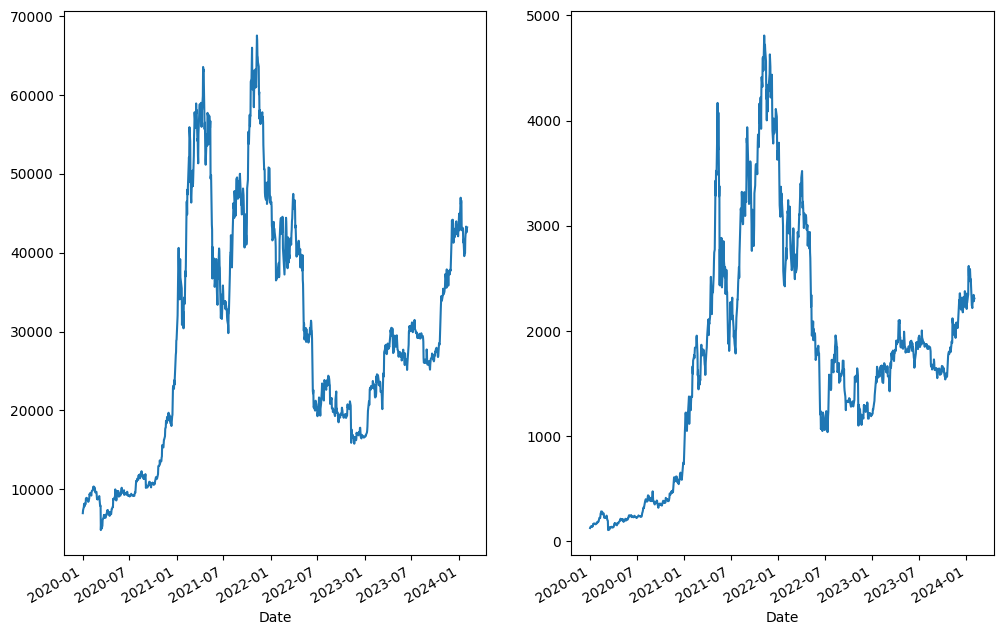

In [51]:
fig,axes = plt.subplots(ncols = 2, figsize = (12,8))
df_cripto['Bitcoin_Price'].plot(ax = axes[0])
df_cripto['Ethereum_Price'].plot(ax = axes[1])

In [52]:
df_cripto_predict = (
    df_cripto
    .assign(Btc_fut = df_cripto['Bitcoin_Price'].shift(1))
    .assign(Eth_fut = df_cripto['Ethereum_Price'].shift(1))
)


In [53]:
df_cripto_predict

,Bitcoin_Price,Ethereum_Price,Btc_fut,Eth_fut
Date,,,,
2024-02-02,43194.7,2309.28,NaN,NaN
2024-02-01,43081.4,2304.28,43194.7,2309.28
2024-01-31,42580.5,2283.14,43081.4,2304.28
2024-01-30,42946.2,2343.11,42580.5,2283.14
2024-01-29,43299.8,2317.79,42946.2,2343.11
...,...,...,...,...
2020-01-08,8059.6,140.81,7842.4,137.92
2020-01-07,8155.7,143.04,8059.6,140.81
2020-01-06,7759.1,144.08,8155.7,143.04


In [54]:
df_cripto_predict.drop('2024-02-02', inplace = True)

In [55]:
threshold = np.quantile(df_cripto_predict.index,0.95)
train = df_cripto_predict.loc[df_cripto_predict.index < threshold]
test = df_cripto_predict.loc[df_cripto_predict.index > threshold]

In [56]:
X_train_btc,y_train_btc = train['Bitcoin_Price'],train['Btc_fut']
X_test_btc,y_test_btc = test['Bitcoin_Price'],test['Btc_fut']
X_train_eth,y_train_eth= train['Ethereum_Price'],train['Eth_fut']
X_test_eth,y_test_eth= test['Ethereum_Price'],test['Eth_fut']


In [57]:
XGB = XGBRegressor()
XGB.fit(X_train_btc,y_train_btc)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
y_pred_btc = XGB.predict(X_test_btc)

In [59]:
print_metrics(y_pred_btc,y_test_btc)

MAE 1547.824394914216
MSE 3904176.0664197775
RMSE 1975.898799640249


In [60]:
datas_previsao = np.asarray(X_test_btc.index)
datas = np.asarray(df_cripto_predict.index)

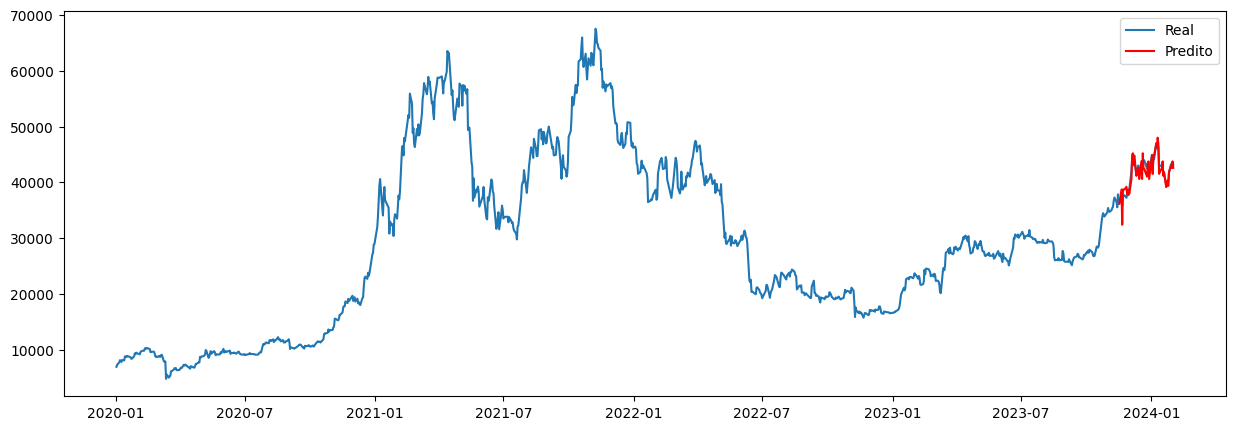

In [61]:
fig = plt.figure(figsize = (15,5))
plt.plot(datas, df_cripto_predict['Bitcoin_Price'].values, label = 'Real')
plt.plot(datas_previsao, y_pred_btc, label = 'Predito', color = 'red')
plt.legend()

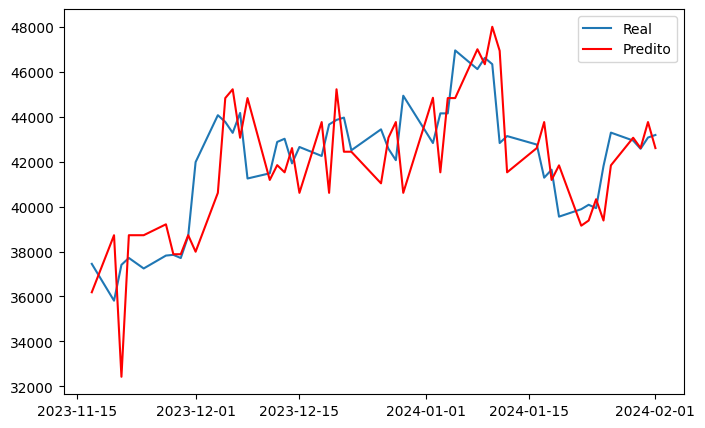

In [62]:
fig = plt.figure(figsize = (8,5))
plt.plot(datas_previsao, y_test_btc, label = 'Real')
plt.plot(datas_previsao, y_pred_btc, label = 'Predito', color = 'red')
plt.legend()

Agora vou fazer o mesmo pro ethereum

In [63]:
XGB = XGBRegressor()
XGB.fit(X_train_eth,y_train_eth)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [64]:
y_pred_eth = XGB.predict(X_test_eth)

In [65]:
print_metrics(y_pred_eth,y_test_eth)

MAE 79.14514926087624
MSE 10725.282618312756
RMSE 103.56294037112289


In [66]:
datas_previsao = np.asarray(X_test_eth.index)
datas = np.asarray(df_cripto_predict.index)

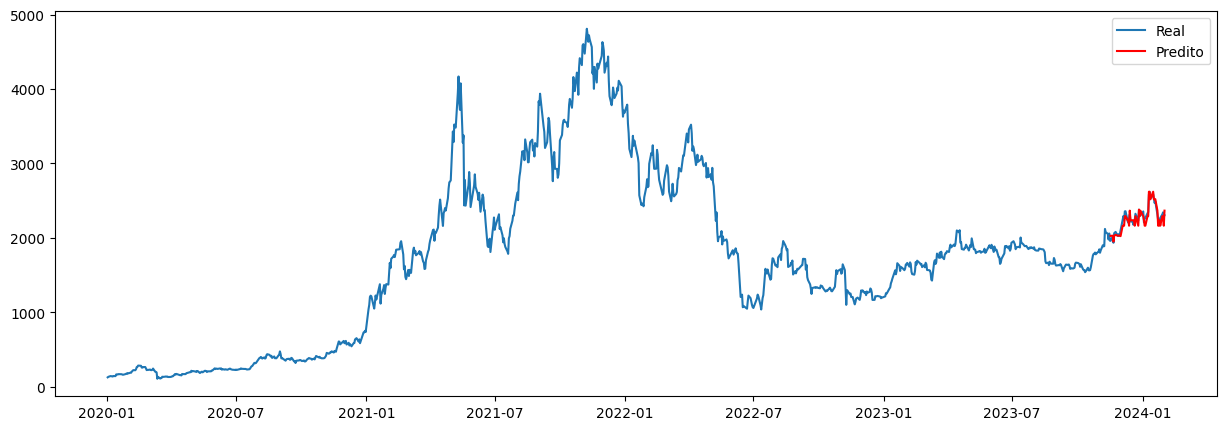

In [67]:
fig = plt.figure(figsize = (15,5))
plt.plot(datas, df_cripto_predict['Ethereum_Price'].values, label = 'Real')
plt.plot(datas_previsao, y_pred_eth, label = 'Predito', color = 'red')
plt.legend()

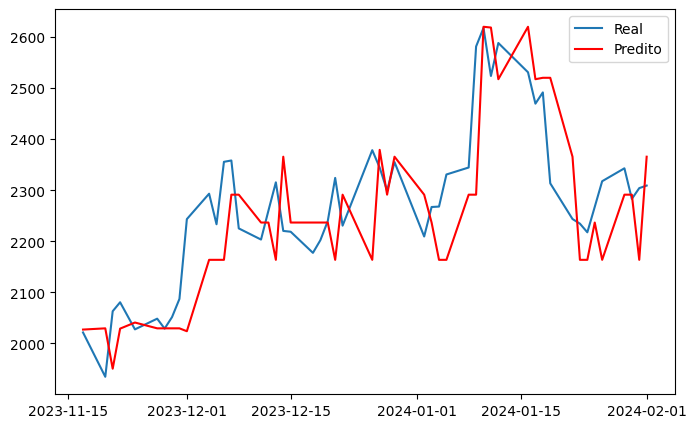

In [68]:
fig = plt.figure(figsize = (8,5))
plt.plot(datas_previsao, y_test_eth, label = 'Real')
plt.plot(datas_previsao, y_pred_eth, label = 'Predito', color = 'red')
plt.legend()